In [1]:
import datetime as dt
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yfinance as yf
import matplotlib.pyplot as plt

pyo.init_notebook_mode(connected=True)
pd.options.plotting.backend = 'plotly'

In [13]:
end = dt.datetime.now()
start = dt.datetime(2017,1,1)

yf.pdr_override()

df = pdr.get_data_yahoo(['TSLA', 'GOOGL','ABC'], start, end)

Close = df.Close
Close.head()


[*********************100%***********************]  3 of 3 completed


,ABC,GOOGL,TSLA
Date,,,
2017-01-03,82.610001,40.400501,14.466000
2017-01-04,84.660004,40.388500,15.132667
2017-01-05,83.680000,40.651001,15.116667
2017-01-06,84.800003,41.260502,15.267333
2017-01-09,85.480003,41.359001,15.418667


In [3]:
# Computing log returns

log_returns = np.log(df.Close/df.Close.shift(1)).dropna()
log_returns

,ABC,GOOGL,TSLA
Date,,,
2017-01-04,0.024513,-0.000297,0.045055
2017-01-05,-0.011643,0.006478,-0.001058
2017-01-06,0.013296,0.014882,0.009918
2017-01-09,0.007987,0.002384,0.009863
2017-01-10,-0.007633,-0.001415,-0.006115
...,...,...,...
2023-07-24,-0.005937,0.012503,0.034176
2023-07-25,0.002296,0.005580,-0.014149
2023-07-26,-0.022024,0.056162,-0.003512


In [4]:
# Computing standard deviations

daily_std = log_returns.std()
annualized_std = daily_std * np.sqrt(252)
annualized_std

ABC      0.284226
GOOGL    0.297088
TSLA     0.612509
dtype: float64

## Histogram of log returns with their annulized volatilties

In [5]:
fig = make_subplots(rows=2, cols=2)

trace0 = go.Histogram(x=log_returns['TSLA'], name='TSLA')
trace1 = go.Histogram(x=log_returns['GOOGL'], name='GOOGL')
trace2 = go.Histogram(x=log_returns['ABC'], name='ABC')


fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig.update_layout(autosize = False, width=700, height=600, title='Frequency of log returns',
                  xaxis=dict(title='TSLA Annualized Volatility: ' + str(np.round(annualized_std['TSLA']*100, 1))),
                  xaxis2=dict(title='GOOGL Annualized Volatility: ' + str(np.round(annualized_std['GOOGL']*100, 1))),
                  xaxis3=dict(title='ABC Annualized Volatility: ' + str(np.round(annualized_std['ABC']*100, 1))))

fig.show()


## Trailing Volatility over time

Another way to visualise volatility (as opposed to annulized or daily single figure):

    - just plotting everyday's std


In [6]:
LOOKBACK_PERIOD = 60
volatility = log_returns.rolling(window=LOOKBACK_PERIOD).std()*np.sqrt(LOOKBACK_PERIOD)

volatility.plot()

### It is nice to compare this to the stock price:

In [7]:
Close.plot()

# Sharpe Ratio

A measure for calculating risk-adjusted return. The Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility.

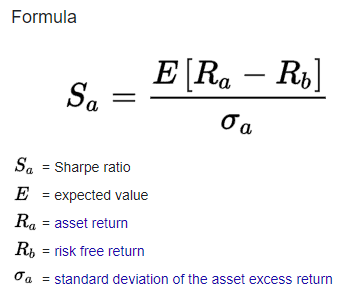

Basically; average return over time / units of volatility over time

In [8]:
# risk free rate
Rf = 0.01/252  

# Sharpe ratio - rolling over time
sharpe_ratio = (log_returns.rolling(window=LOOKBACK_PERIOD).mean() - Rf) *LOOKBACK_PERIOD/volatility 
# (returns - daily rff) * lookback / volatility



We need to multiply by

       lookback * 1 / volatility
   
because dividing by volatility dataframe, we have specified that many lookback period to calculate std.

In [9]:
sharpe_ratio.plot()

This is very helpful in understanding how the mean and volatility change over time. More useful to have rolling ratio than single figure over one period.

# Sortino Ratio

## Similar to Sharpe Ratio, but instead of using all observations to calculate std, the Sortino only considers harmful variance

In [10]:
# Start by taking only negative volatilties
sortino_vol = log_returns[log_returns<0].rolling(window=LOOKBACK_PERIOD, center=True, min_periods=4).std()*np.sqrt(LOOKBACK_PERIOD)

# Same as before
sortino_ratio = (log_returns.rolling(window=LOOKBACK_PERIOD).mean() - Rf) *LOOKBACK_PERIOD/sortino_vol 

sortino_vol.plot()

In [11]:
sortino_ratio.plot()

# Modigliani Ratio (M2 Ratio)

### Modigliani Ratio measure the returns of the portfolio, adjusted for the risk of the portfolio relative to that of some benchmark.

### e.g Take benchmark volatility (some market index) and then use that volatility to benchmark risk of our portfolio

In [33]:
df_sp500 = pdr.get_data_yahoo(['^GSPC'], start, end)

Close_sp500 = df_sp500.Close

log_returns_sp500 = np.log(df_sp500.Close/df_sp500.Close.shift(1)).dropna()

volatility_sp500 = log_returns_sp500.rolling(window=LOOKBACK_PERIOD).std() * np.sqrt(LOOKBACK_PERIOD)

volatility_sp500.plot()


[*********************100%***********************]  1 of 1 completed


In [47]:
m2_ratio = pd.DataFrame()



log_returns_sp500 = pd.Series(log_returns_sp500, name='S&P500')

log_returns = pd.concat([log_returns, log_returns_sp500], axis=1)


Date
2017-01-04    0.005706
2017-01-05   -0.000771
2017-01-06    0.003511
2017-01-09   -0.003555
2017-01-10    0.000000
                ...   
2023-07-24    0.004026
2023-07-25    0.002811
2023-07-26   -0.000155
2023-07-27   -0.006445
2023-07-28    0.009829
Name: S&P500, Length: 1652, dtype: float64
<class 'pandas.core.frame.DataFrame'>
                 ABC     GOOGL      TSLA    S&P500    S&P500
Date                                                        
2017-01-04  0.024513 -0.000297  0.045055  0.005706  0.005706
2017-01-05 -0.011643  0.006478 -0.001058 -0.000771 -0.000771
2017-01-06  0.013296  0.014882  0.009918  0.003511  0.003511
2017-01-09  0.007987  0.002384  0.009863 -0.003555 -0.003555
2017-01-10 -0.007633 -0.001415 -0.006115  0.000000  0.000000
...              ...       ...       ...       ...       ...
2023-07-24 -0.005937  0.012503  0.034176  0.004026  0.004026
2023-07-25  0.002296  0.005580 -0.014149  0.002811  0.002811
2023-07-26 -0.022024  0.056162 -0.003512 -0.000155 

In [52]:
benchmark_vol = volatility_sp500






for c in log_returns.columns:
    if c != 'S&P500':
        m2_ratio[c] = (sharpe_ratio[c] * benchmark_vol/LOOKBACK_PERIOD + Rf) * LOOKBACK_PERIOD

m2_ratio.plot()

## M2 Ratio, here we see percentage changes over time with respect to market index volatility.

# Max Drawdown

### Max drawdown quantifies the steepest decline from peak to trough observed for an investment. This doesn't rely on underlying asset being Gaussian.

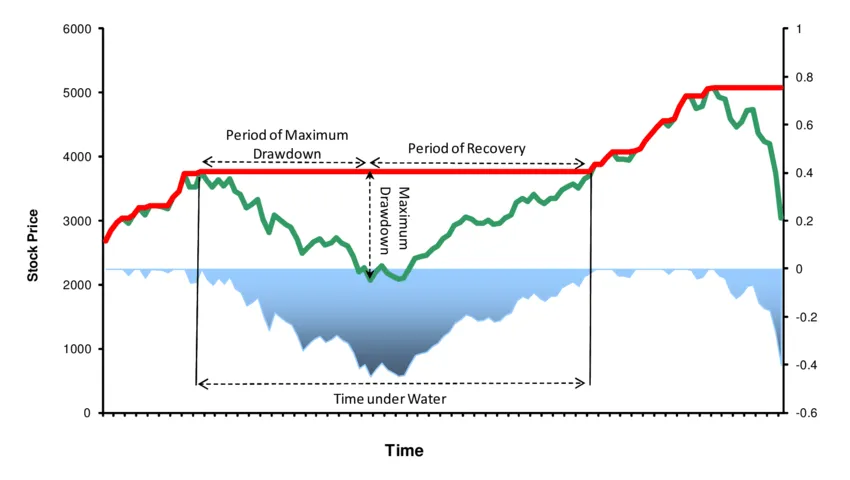

In [62]:
def max_drawdown(returns):
    cumulative_returns = (1+returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()   # Finding peak of cumulative returns
    drawdown = (cumulative_returns/peak) - 1
    return drawdown.min()   # As we divide by peak, we want to minimise it to find max drawdown over that time period.

returns = df.Close.pct_change().dropna()

max_drawdowns = returns.apply(max_drawdown, axis=0)

max_drawdowns*100 # as percentage

ABC     -32.916193
GOOGL   -44.320051
TSLA    -73.632217
dtype: float64

# With these Maximum Drawdowns, we can calculate Calmar Ratio

## Calmar Ratio puts max drawdown in context, it uses those percentages instead of volatility:    
## returns / max_drawdown, instead of 
## returns / volatility

#### Also note that TSLA had highest variances and also highest max drawdown!


In [65]:
calmars_numerator = np.exp(log_returns.mean()*252) # Absolute return over 252 days
calmars = calmars_numerator / abs(max_drawdowns)

calmars.plot.bar()

## ABC has the highest return vs risk, S&P 500 doesn't have volatility calculate, this can be added in later, it will likely have the best ratio!